#### Sept. 22, 2017

Generate input csv files (from breseq output of annotated.gd) for plotting with the following code snippets from ```lost_polymorphisms.py``` and ```plot_polymorphisms.py```:

In [1]:
import numpy as np
import pandas as pd
import re
import glob
import matplotlib.pyplot as plt

In [2]:
## Two relevant functions from class ComparePolymorphisms, in lost_polymorphisms.py

def get_all_gd(self, evolution_line, input_directory, path_to_ancestor_gd):
    '''
    Input1: name of evolution line
    Input2: directory path to all breseq results
    Input3: path to GenomeDiff file for ancestral (generation 0) population.
    Output: GD files for all generations of the evolution line, concatenated as one data frame.
    '''
    ancestor_df = self.annotated_gd_to_df(path_to_ancestor_gd, 0)
    annotated_gd_files = glob.glob(input_directory + '*' + evolution_line + '*/output/*.gd')
    print(annotated_gd_files)
    all_dataframes = [ancestor_df]
    for genome_diff in annotated_gd_files:
        generation = int(genome_diff[-8:-3].split('-')[1])
        dataframe = self.annotated_gd_to_df(genome_diff, generation)
        all_dataframes.append(dataframe)
    evolution_line_dataframe = pd.concat(all_dataframes, ignore_index=True)
    evolution_line_dataframe.insert(0, 'line', evolution_line)
    return evolution_line_dataframe

def gd_frequencies_to_df(self, df_from_all_gd, save_csv=False, csv_filename='gd_freqs.csv'):
    '''
    Input: output from get_all_gd(), i.e., data frame of combined gd files from one evolution line.
    Output: data frame of all polymorphisms with frequencies, for plotting.
    '''
    df_from_all_gd.insert(2, 'consensus_frequency', 'NaN')
    df_from_all_gd.insert(3, 'polymorphism_frequency', 0.0)
    df_from_all_gd.rename(columns = {0: 'entry_type', 1: 'item_id', 2: 'evidence_id', 3: 'genome_id', 4: 'position', 5: 'mutation_detail'}, inplace=True)
    # entry types obtained from http://barricklab.org/twiki/pub/Lab/ToolsBacterialGenomeResequencing/documentation/gd_format.html
    df_polymorphisms = df_from_all_gd[(df_from_all_gd['entry_type'] == 'INS') | (df_from_all_gd['entry_type'] == 'DEL') | 
            (df_from_all_gd['entry_type'] == 'SNP') | (df_from_all_gd['entry_type'] == 'SUB') | (df_from_all_gd['entry_type'] == 'MOB') | 
            (df_from_all_gd['entry_type'] == 'AMP') | (df_from_all_gd['entry_type'] == 'CON') | (df_from_all_gd['entry_type'] == 'INV')].copy()
    for row in df_polymorphisms.itertuples():
        for col_index in range(6, 51):
            if re.match('frequency', str(df_polymorphisms.loc[row[0], col_index])):
                df_polymorphisms.loc[row[0], 'polymorphism_frequency'] = re.sub('frequency=', '', str(df_polymorphisms.loc[row[0], col_index]))
                if df_polymorphisms.loc[row[0], 'polymorphism_frequency'] == '1':
                    df_polymorphisms.loc[row[0], 'consensus_frequency'] = 1.0
                    evidence_id = df_polymorphisms.loc[row[0], 'evidence_id']
                    evidence_row = df_from_all_gd[df_from_all_gd['item_id'] == evidence_id].index
                    for evidence_col in range(6, 51):
                        if re.match('polymorphism_frequency', str(df_from_all_gd.loc[evidence_row, evidence_col])):
                            df_polymorphisms.loc[row[0], 'polymorphism_frequency'] = re.sub('polymorphism_frequency=', '', str(df_from_all_gd.loc[evidence_row, evidence_col]))
                        break
            break
                
    df_polymorphisms_for_plotting = df_polymorphisms[['line', 'generation', 'entry_type', 'item_id', 'mutation_detail',  
                                                      'genome_id', 'position', 'polymorphism_frequency', 'consensus_frequency']].copy()
    dtype = {'line': str, 'generation': int, 'entry_type': str, 'item_id': str, 'genome_id': str,
             'position': str, 'polymorphism_frequency': float, 'consensus_frequency': float}
    for key, value in dtype.items():
        df_polymorphisms_for_plotting[key] = df_polymorphisms_for_plotting[key].astype(value)
    if save_csv == True:
        df_polymorphisms_for_plotting.to_csv(csv_filename, index=False)
    
    return df_polymorphisms_for_plotting

```
## Script from plot_polymorphisms.py

from lost_polymorphisms import ComparePolymorphisms

input_directory = '~/breseq_results/'
output_directory = '~/plot_polymorphisms/results/'
ancestor_gd_path = input_directory + 'sic_Ancestor_breseq/output/0.gd'
evolution_lines = ['HA3', 'HE3', 'HR2', 'HS3', 'UA3', 'UE3', 'UR1', 'US1']

cp_gd = ComparePolymorphisms()
for line in evolution_lines:
    line_df = cp_gd.get_all_gd(line, input_directory, ancestor_gd_path)
    output_csv = output_directory + line + '_gd_freqs.csv'
    frequencies_df = cp_gd.gd_frequencies_to_df(line_df, save_csv=True, csv_filename=output_csv)
```

In [3]:
all_csv = glob.glob('/Users/ymseah/Repositories/dataviz/data/*_gd_freqs.csv')
df_list = []
for csv in all_csv:
    df = pd.read_csv(csv)
    df_list.append(df)
all_df = pd.concat(df_list, ignore_index=True)
all_df['polymorphism'] = all_df['position'].astype(str).str.cat(all_df['entry_type'], sep=' ').str.cat(all_df['mutation_detail'], sep=' ')
all_df = all_df[['line', 'genome_id', 'generation', 'polymorphism', 'polymorphism_frequency']].copy()
all_df_pvt = all_df.pivot_table(index=['genome_id', 'line', 'generation'], columns='polymorphism', values='polymorphism_frequency')

In [4]:
dvh_df = all_df_pvt.loc['NC_002937'].dropna(axis=1, how='all')
mm_df = all_df_pvt.loc['NC_005791'].dropna(axis=1, how='all')
dvplasmid_df = all_df_pvt.loc['NC_005863'].dropna(axis=1, how='all')

In [10]:
def fluctuating_bools(df):
    '''
    Returns 2 lists of alternating bool values. Default list length is the number of indexes in df.
    '''
    true_false = []
    false_true = []
    count = 0
    while count < len(df.index.tolist()):
        true_false.append(True)
        false_true.append(False)
        count += 1
        if count < len(df.index.tolist()):
            true_false.append(False)
            false_true.append(True)
            count += 1
    return true_false, false_true

def greater_than_last_gen(df):
    '''Compares if frequencies in each row greater than in previous row, 
    returns df of bool values'''
    comparisons = {}
    count = 0
    while count < len(df.index)-1:
        comparisons[str(count+1) + '_to_' + str(count)] = df.loc[df.index[count+1]] > df.loc[df.index[count]]
        count += 1
    compare_df = pd.DataFrame(comparisons).T
    return compare_df

def subset_fluctuating_frequencies(df):
    '''Returns list of df columns with fluctuating polymorphisms'''
    t_f, f_t = fluctuating_bools(df)
    fluctuating_polymorphisms = []
    for col in df.columns:
        if (df[col].tolist() == t_f) | (df[col].tolist() == f_t):
            fluctuating_polymorphisms.append(col)
    return fluctuating_polymorphisms

def subset_some_fluctuation(df, tf_len=3):
    t_f, f_t = fluctuating_bools(df)
    some_t_f = t_f[:tf_len]
    some_f_t = f_t[:tf_len]
    some_flux = []
    for col in df.columns:
        bools_list = df[col].tolist()
        count = 0
        while count <= (len(bools_list)-3):
            bools_slice = bools_list[count:(count+3)]
            if (bools_slice == some_t_f) | (bools_slice == some_f_t):
                some_flux.append(col)
            count += 1
    return list(set(some_flux))

def subset_monotonic(df):
    '''
    Returns 2 lists of column names that have monotonically increasing, and decreasing values. 
    '''
    mono_inc = []
    mono_dec = []
    for col in df.columns:
        if df[col].is_monotonic_increasing:
            mono_inc.append(col)
        elif df[col].is_monotonic_decreasing:
            mono_dec.append(col)
    return mono_inc, mono_dec

# Plotting functions

def plot_fluctuating(df, some_flux=False, flux_len=3):
    compare_freqs = greater_than_last_gen(df)
    if some_flux == False:
        flux = subset_fluctuating_frequencies(compare_freqs)
    else:
        flux = subset_some_fluctuation(compare_freqs, tf_len = flux_len)
    df[flux].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)   

def plot_line_summary(line, df, plottitle):
    data = df.loc[line.upper()].dropna(axis=1, how='all').fillna(0)
    # monotonic
    inc, dec = subset_monotonic(data)
    fig, axes = plt.subplots(5,1, sharex=True)
    if len(inc) > 0:
        data[inc].plot(ax=axes[0], legend=False, title=plottitle)
    else:
        axes[0].set_title(plottitle)
    if len(dec) > 0:
        data[dec].plot(ax=axes[1], legend=False)
    # all fluctuating
    compare_freqs = greater_than_last_gen(data)
    flux = subset_fluctuating_frequencies(compare_freqs)
    if len(flux) > 0:
        data[flux].plot(ax=axes[2], legend=False)
    # some fluctuating
    flux2 = subset_some_fluctuation(compare_freqs)
    for each in flux:
        flux2.remove(each)
    if len(flux2) > 0:
        data[flux2].plot(ax=axes[3], legend=False)
    # others
    oth = []
    for col in data.columns:
        if (col not in inc) & (col not in dec) & (col not in flux) & (col not in flux2):
            oth.append(col)
    if len(oth) > 0:
        data[oth].plot(ax=axes[4], legend=False)
    plt.savefig(plottitle + '_summary.png')

def plot_line_individual(line, df, genome_id):
    data = df.loc[line.upper()].dropna(axis=1, how='all').fillna(0)
    inc, dec = subset_monotonic(data)
    compare_freqs = greater_than_last_gen(data)
    flux = subset_fluctuating_frequencies(compare_freqs)
    flux2 = subset_some_fluctuation(compare_freqs)
    for each in flux:
        flux2.remove(each)

    if len(inc) > 0:
        data[inc].plot(title = line.upper() + ':' + genome_id + ' is_monotonic_increasing', figsize=(20,15)).legend(loc='upper left', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_monotonic_increasing.png')
    if len(dec) > 0:
        data[dec].plot(title = line.upper() + ':' + genome_id + ' is_monotonic_decreasing', figsize=(20,15)).legend(loc='upper right', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_monotonic_decreasing.png')
    if len(flux) > 0:
        data[flux].plot(title = line.upper() + ':' + genome_id + ' fluctuating', figsize=(20,15)).legend(loc='upper right', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_fluctuating.png')
    if len(flux2) > 0:
        data[flux2].plot(title = line.upper() + ':' + genome_id + ' some fluctuating', figsize=(20,15)).legend(loc='upper right', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_some_fluctuating.png')

    oth = []
    for col in data.columns:
        if (col not in inc) & (col not in dec) & (col not in flux) & (col not in flux2):
            oth.append(col)
    if len(oth) > 0:
        data[oth].plot(title = line.upper() + ':' + genome_id + ' others', figsize=(20,15)).legend(loc='upper right', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_others.png')

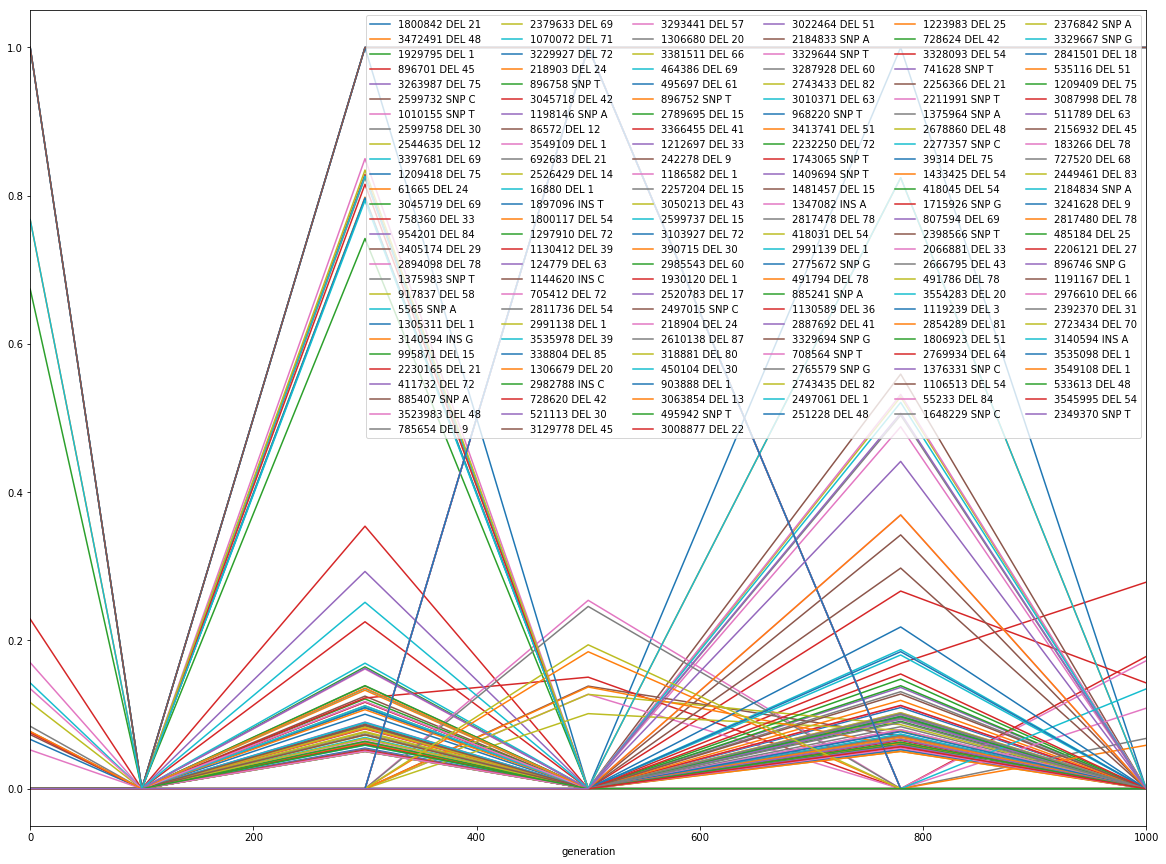

In [12]:
%matplotlib inline
ua3dvh = dvh_df.loc['UA3'].dropna(axis=1, how='all').fillna(0)
ua3dvh_compare = greater_than_last_gen(ua3dvh)
plot_fluctuating(ua3dvh, some_flux=True)
plt.savefig('ua3dvh_flux.png')

In [88]:
ua3dvh_compare

polymorphism,1000532 SNP G,1000538 SNP G,1010155 SNP T,1016229 DEL 67,1024609 DEL 24,1070072 DEL 71,1106513 DEL 54,1119239 DEL 3,1130412 DEL 39,1130589 DEL 36,...,896752 SNP T,896758 SNP T,898539 SUB 85,903888 DEL 1,917837 DEL 58,933092 DEL 1,954201 DEL 84,963632 DEL 86,968220 SNP T,995871 DEL 15
1_to_0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2_to_1,False,False,False,False,False,True,True,False,True,False,...,True,True,False,True,False,False,False,True,True,False
3_to_2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4_to_3,False,False,True,False,False,False,False,True,False,True,...,False,False,False,False,True,False,True,False,False,True
5_to_4,True,True,False,True,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


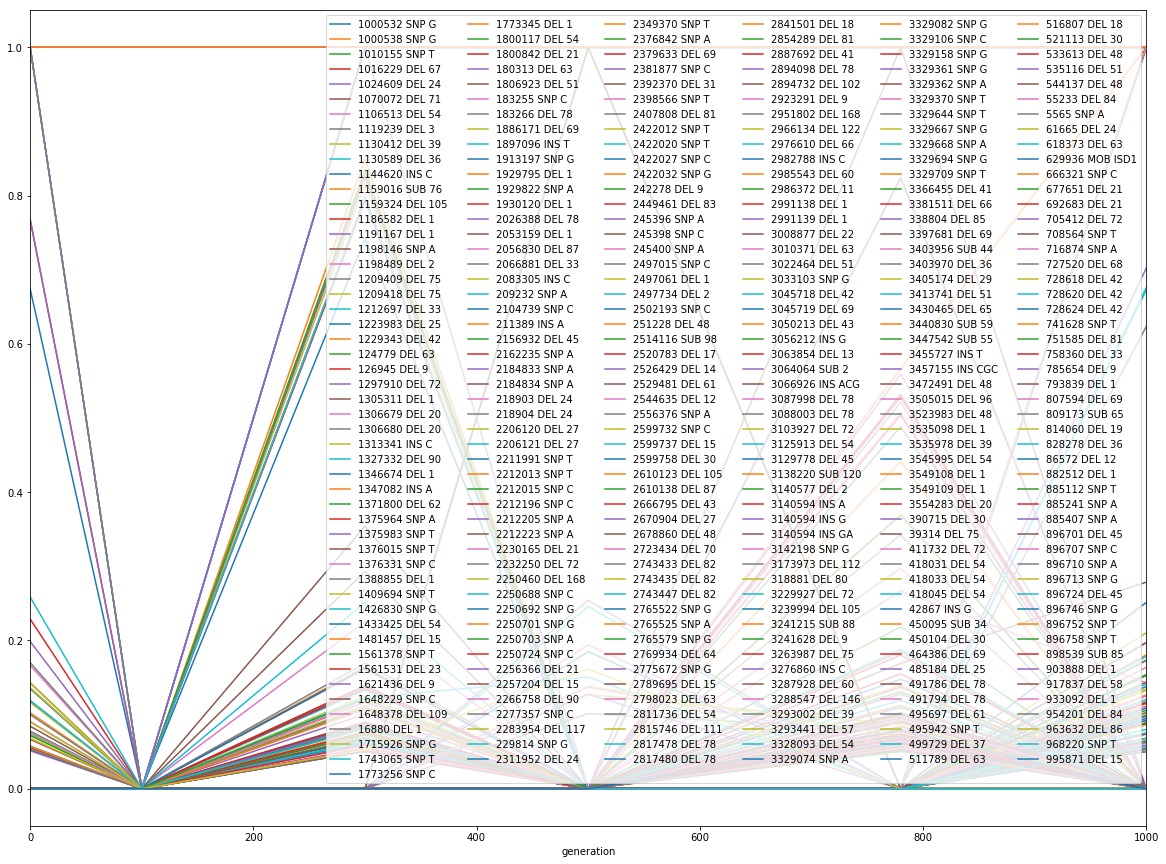

In [108]:
ua3dvh.plot(figsize = (20,15)).legend(loc='upper right', ncol=6)

In [103]:
peak1=[]
peak2=[]
peak3=[]
peak4=[]
peak5=[]
for polym in ua3dvh_compare.columns.tolist():
    if ua3dvh_compare.loc['1_to_0', polym] == True:
        peak1.append(polym)
    if ua3dvh_compare.loc['2_to_1', polym] == True:
        peak2.append(polym)
    if ua3dvh_compare.loc['3_to_2', polym] == True:
        peak3.append(polym)
    if ua3dvh_compare.loc['4_to_3', polym] == True:
        peak4.append(polym)
    if ua3dvh_compare.loc['5_to_4', polym] == True:
        peak5.append(polym)

others=[]
peak_all = set(peak1 + peak2 + peak3 + peak4 + peak5)
for polym in ua3dvh_compare.columns.tolist():
    if polym not in peak_all:
        others.append(polym)

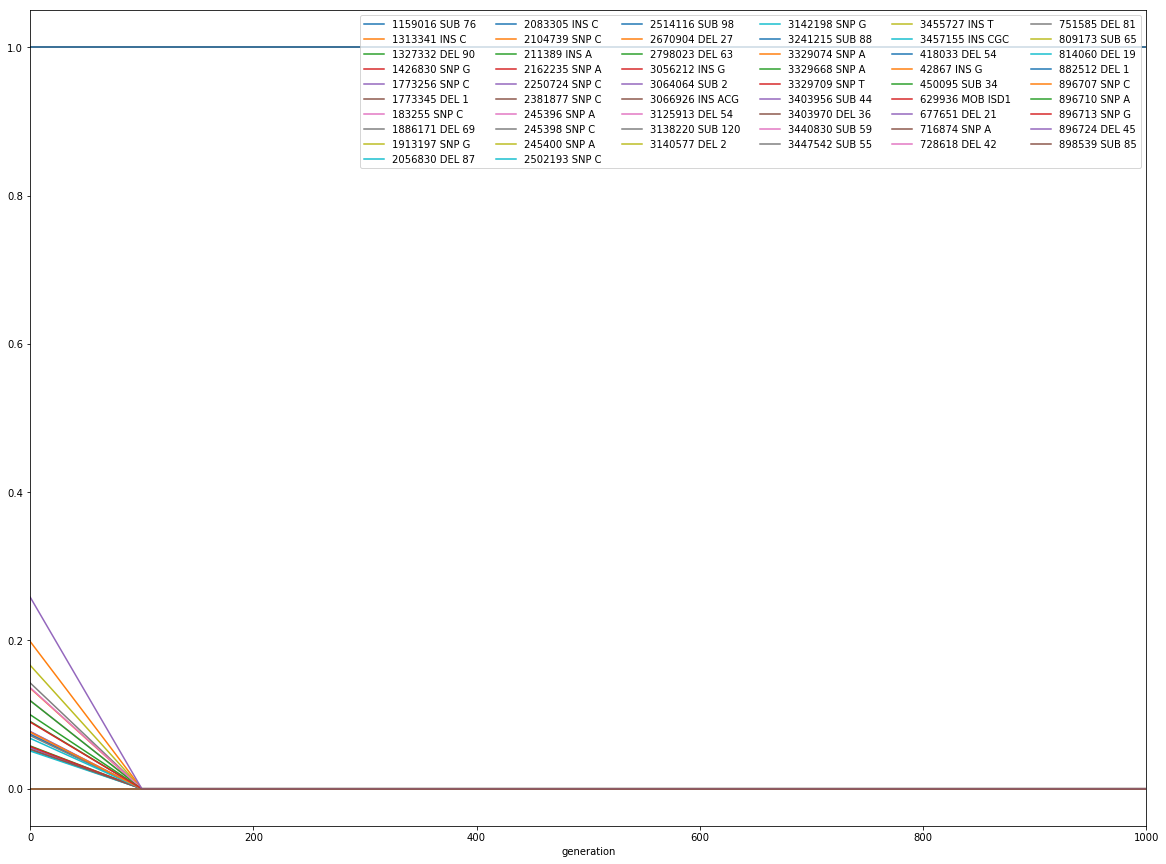

In [105]:
ua3dvh[others].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_peak_none.png')

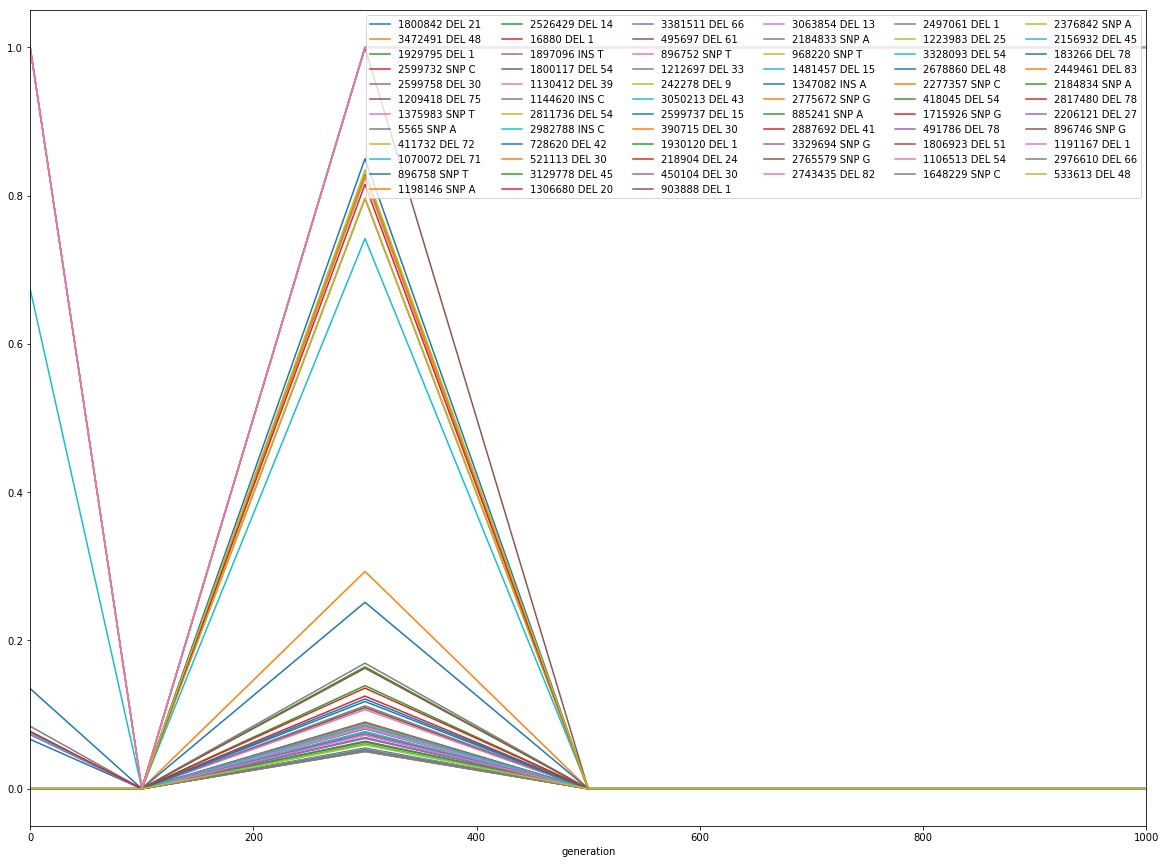

In [54]:
flux_polymorphisms = subset_some_fluctuation(ua3dvh_compare)
ua3dvh_flux = ua3dvh_compare[flux_polymorphisms].T
#ua3dvh_flux
ftfff = ua3dvh_flux[(ua3dvh_flux['1_to_0'] == False) & (ua3dvh_flux['2_to_1'] == True) & 
           (ua3dvh_flux['3_to_2'] == False) & (ua3dvh_flux['4_to_3'] == False) & (ua3dvh_flux['5_to_4'] == False)]
ua3dvh[ftfff.index.tolist()].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_ftfff.png')

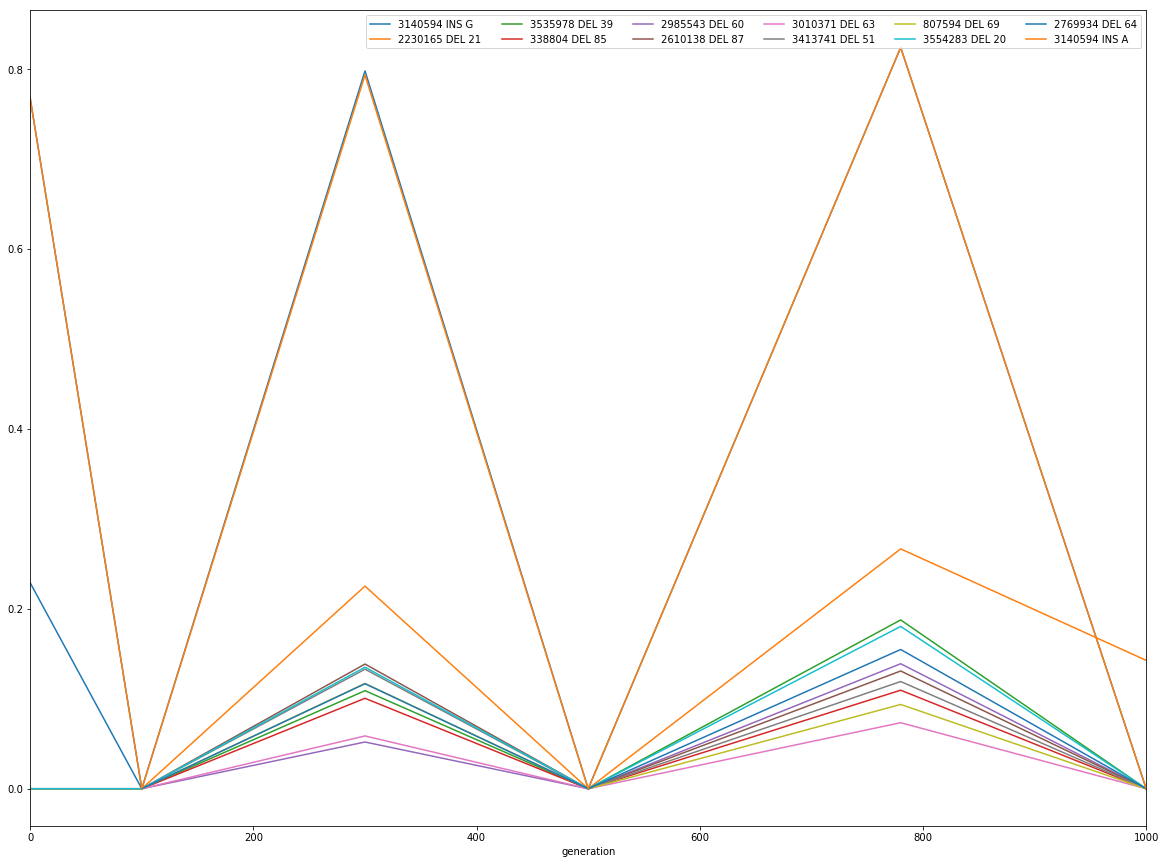

In [55]:
ftftf = ua3dvh_flux[(ua3dvh_flux['1_to_0'] == False) & (ua3dvh_flux['2_to_1'] == True) & 
           (ua3dvh_flux['3_to_2'] == False) & (ua3dvh_flux['4_to_3'] == True) & (ua3dvh_flux['5_to_4'] == False)]
ua3dvh[ftftf.index.tolist()].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_ftftf.png')

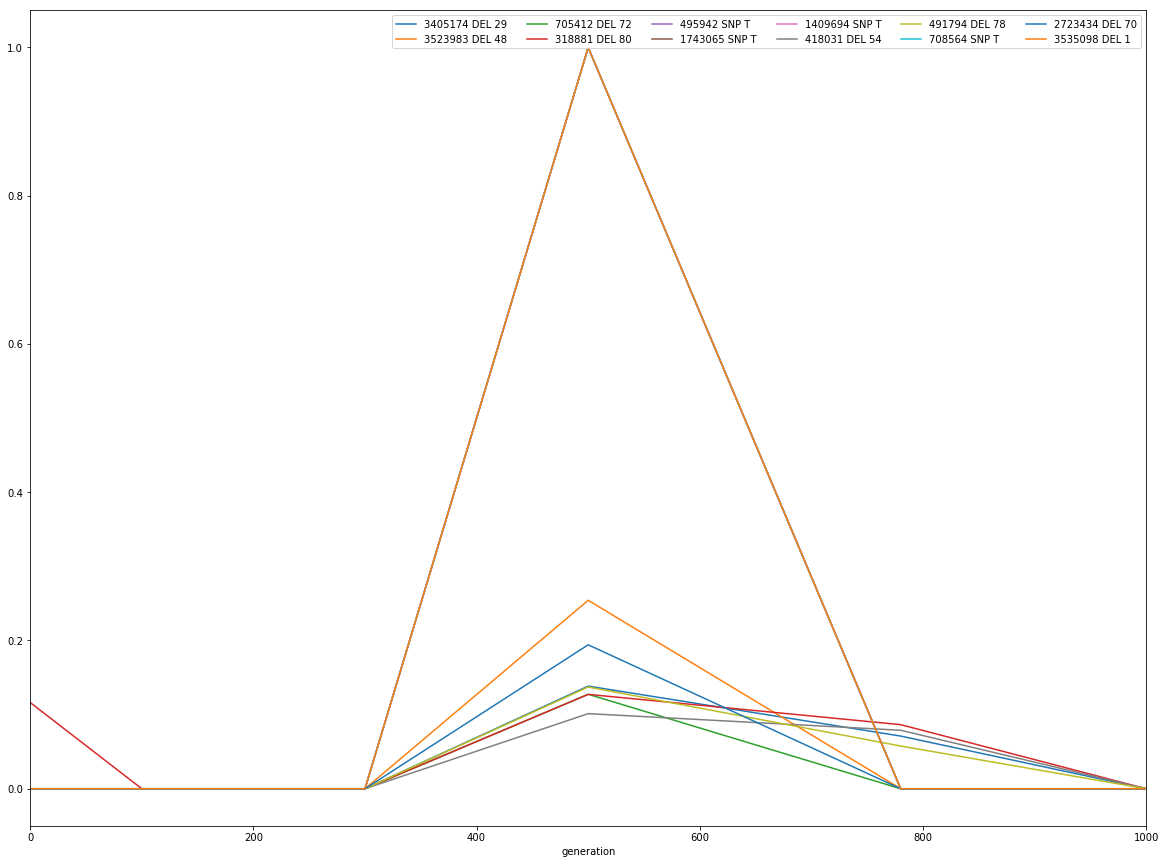

In [57]:
fftff = ua3dvh_flux[(ua3dvh_flux['1_to_0'] == False) & (ua3dvh_flux['2_to_1'] == False) & 
           (ua3dvh_flux['3_to_2'] == True) & (ua3dvh_flux['4_to_3'] == False) & (ua3dvh_flux['5_to_4'] == False)]
ua3dvh[fftff.index.tolist()].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_fftff.png')

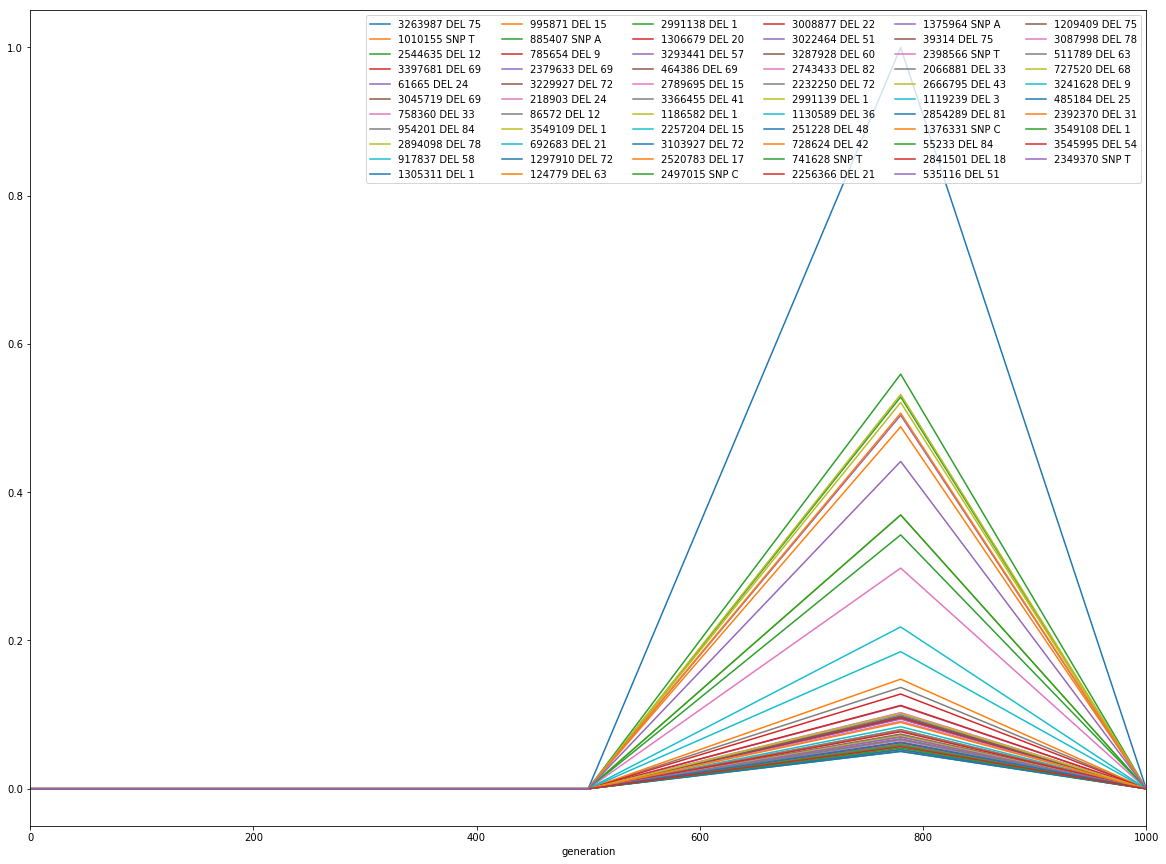

In [58]:
ffftf = ua3dvh_flux[(ua3dvh_flux['1_to_0'] == False) & (ua3dvh_flux['2_to_1'] == False) & 
           (ua3dvh_flux['3_to_2'] == False) & (ua3dvh_flux['4_to_3'] == True) & (ua3dvh_flux['5_to_4'] == False)]
ua3dvh[ffftf.index.tolist()].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_ffftf.png')

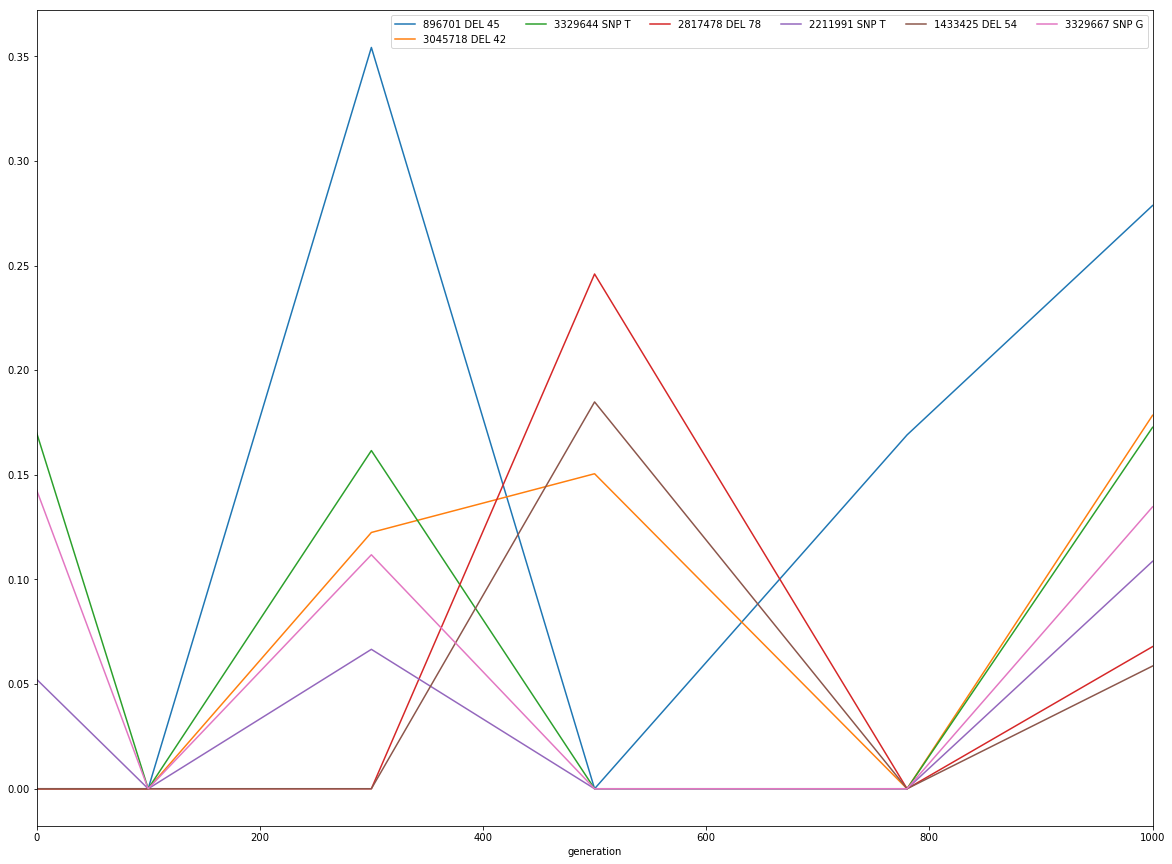

In [106]:
others = []
for row in ua3dvh_flux.index.tolist():
    if (row not in ftfff.index.tolist()) & (row not in ftftf.index.tolist()) & (row not in fftff.index.tolist()) & (row not in ffftf.index.tolist()):
        others.append(row)
ua3dvh[others].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_others.png')

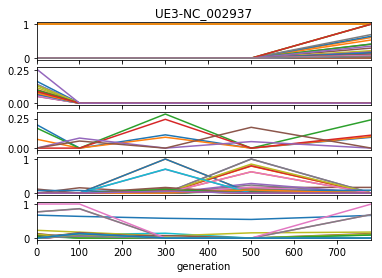

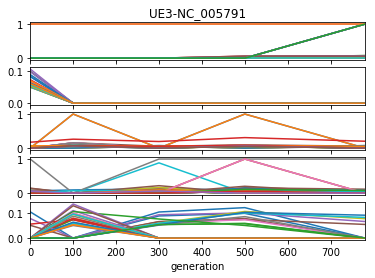

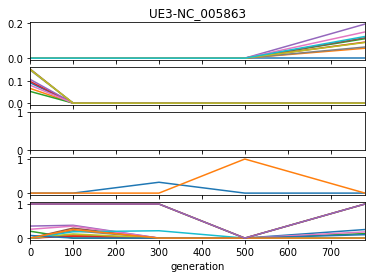

In [6]:
%matplotlib inline
plot_line_summary('ue3', dvh_df, 'UE3-NC_002937')
plot_line_summary('ue3', mm_df, 'UE3-NC_005791')
plot_line_summary('ue3', dvplasmid_df, 'UE3-NC_005863')

In [1]:
#plot_line_individual('ue3', dvplasmid_df, 'NC_005863')

##### R/RStudio envy resulted in...

R code to tidy and plot data initially, with much help from [R for Data Science](http://r4ds.had.co.nz/tidy-data.html#missing-values-3). ~~Will rewrite this in Python, once I've learned it!~~ *Done!*

```
# In plotfreqs.R

library(tidyverse)

get_polymorphisms <- function(filepath) {
  polymorphisms <- read.csv(filepath) %>% 
    unite(polymorphism, position, entry_type, mutation_detail, sep = ' ') %>%
    select(genome_id, polymorphism, generation, polymorphism_frequency) %>% 
    complete(nesting(polymorphism, genome_id), generation, fill = list(polymorphism_frequency = 0))
  return(polymorphisms)
}

plot_polymorphism_frequencies <- function(polymorphism_tibble, output_dir) {
  ggplot(data = polymorphism_tibble, mapping = aes(x = generation, y = polymorphism_frequency)) + 
    geom_line(aes(group = polymorphism)) + 
    facet_wrap(~ genome_id, ncol = 1)
  ggsave(paste(output_dir, 'polymorphism_plot.png', sep = ''), last_plot())
}

# In plot_genotypes.R

source('~/plotfreqs.R')

ue3polymorphisms = get_polymorphisms('~/data/UE3_gd_freqs.csv')
write.csv(ue3polymorphisms, file = '~/ue3polymorphisms.csv', row.names = FALSE, quote = FALSE)
plot_polymorphism_frequencies(ue3polymorphisms, '~/viz/')
```